In [30]:
import numpy as np

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# MNIST
from keras.datasets import mnist

# plot
from matplotlib import pyplot as plt
%matplotlib inline  

from pathlib import Path

from PIL import Image


from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import backend as K

np.random.seed(123)  # for reproducibility

In [31]:
base_path = Path("data")
labels_path = base_path / "labels10k"
image_dirs = {
  "test": base_path / "teste",
  "train": base_path / "treinamento",
  "val": base_path / "validacao",
}

In [32]:
labels = {}
for label_file in labels_path.glob("*.txt"):
  with label_file.open("r") as file:
    labels[label_file.stem] = file.read().strip()

In [33]:
images = {key: [] for key in image_dirs}
for key, image_dir in image_dirs.items():
  images[key] = sorted(image_dir.glob("*.jpg"))

Labels (first 5): [('001953', '2RWRYW'), ('009192', 'BTC6AO'), ('008469', 'FQDU7M'), ('000304', 'QNV1HK'), ('004359', 'XP6QYA')]
Training images (first 5): [PosixPath('data/teste/009001.jpg'), PosixPath('data/teste/009002.jpg'), PosixPath('data/teste/009003.jpg'), PosixPath('data/teste/009004.jpg'), PosixPath('data/teste/009005.jpg')]


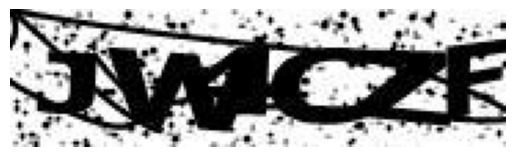

In [34]:
print("Labels (first 5):", list(labels.items())[:5])
print("Training images (first 5):", images["test"][:5])

image_path = images["test"][0]
image = Image.open(image_path)

# Display using matplotlib
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

In [35]:
def split_image_into_subimages(image_path, num_splits=6, target_size=(28, 28)):
  image = Image.open(image_path)
  width, height = image.size
  sub_width = width // num_splits
  subimages = []

  for i in range(num_splits):
    left = i * sub_width
    right = (i + 1) * sub_width
    box = (left, 0, right, height)  # Crop region
    subimage = image.crop(box)
    subimage = subimage.convert("L")
    subimage = subimage.resize(target_size)  # Resize to target size
    subimages.append(np.array(subimage))  # Convert to NumPy array
  
  return subimages


In [36]:
digit_map = {str(i): i for i in range(10)}  # Mapping '0'-'9' to positions 0-9
letter_map = {chr(i): 10 + (i - ord('A')) for i in range(ord('A'), ord('Z') + 1)}  # Mapping 'A'-'Z' to positions 10-35

In [37]:
def encode_to_integer(label_part):
  """Converts a label part (digit or letter) into an integer representation."""
  if label_part.isdigit():
    return int(label_part)  # Return digit as integer
  elif label_part.isalpha():
    return ord(label_part.upper()) - ord('A') + 10  # Map 'A'-'Z' to 10-35
  return 0  # Default case, for robustness

In [38]:
def get_dataset(image_paths, labels):
  X = []
  y = []
  y_original = []

  for image_path in image_paths:
    # Extract the image ID (e.g., "000001" from "000001.jpg")
    image_id = image_path.stem

    # Skip if the label for this image ID is missing
    if image_id not in labels:
      continue

    # Get the label and split it into characters
    label = labels[image_id]
    label_parts = list(label)

    if (len(label) != 6):
      continue

    subimages = split_image_into_subimages(image_path, len(label))

    X.extend(subimages)  
    y.extend([encode_to_integer(part) for part in label_parts]) 
    y_original.extend(label_parts)

  return np.array(X), np.array(y), np.array(y_original)

In [39]:
X_train, y_train, y_original_train = get_dataset(images["train"], labels)
X_test, y_test, y_original_test = get_dataset(images["test"], labels)
X_val, y_val, y_original_val = get_dataset(images["val"], labels)

In [40]:
Y_train = to_categorical(y_train, 36)
Y_test = to_categorical(y_test, 36)
Y_val = to_categorical(y_val, 36)

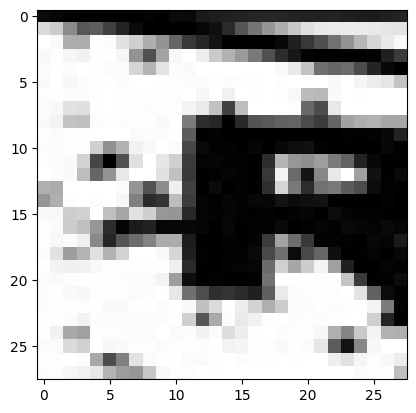

In [41]:
image = X_train[0]
plt.imshow(image, cmap="gray")


(28, 28)
(144,)


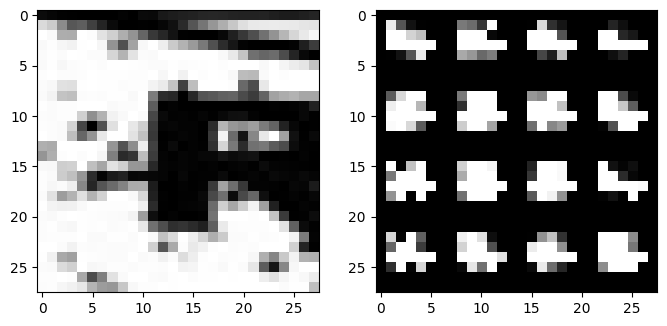

In [42]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(image, orientations=9, pixels_per_cell=(7, 7),
                    cells_per_block=(1, 1), visualize=True)

print(hog_image.shape)
print(fd.shape)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(hog_image_rescaled, cmap="gray")

In [43]:
import numpy as np

def calculate_gradient(matrix):
    """
    Calculate the gradient magnitude and gradient direction of a 2D matrix.
    
    Parameters:
        matrix (numpy.ndarray): 2D input matrix.
    
    Returns:
        tuple: Gradient magnitude (numpy.ndarray), Gradient direction (numpy.ndarray)
    """

    matrix = np.asarray(matrix)

    # Calculate gradients using finite differences
    Gx = np.gradient(matrix, axis=1)  # Gradient along x (columns)
    Gy = np.gradient(matrix, axis=0)  # Gradient along y (rows)

    # Compute gradient magnitude
    grad_magnitude = np.sqrt(Gx**2 + Gy**2)

    # Compute gradient direction (in radians)
    grad_direction = np.arctan2(Gy, Gx)

    return grad_magnitude, grad_direction


(-0.5, 27.5, 27.5, -0.5)

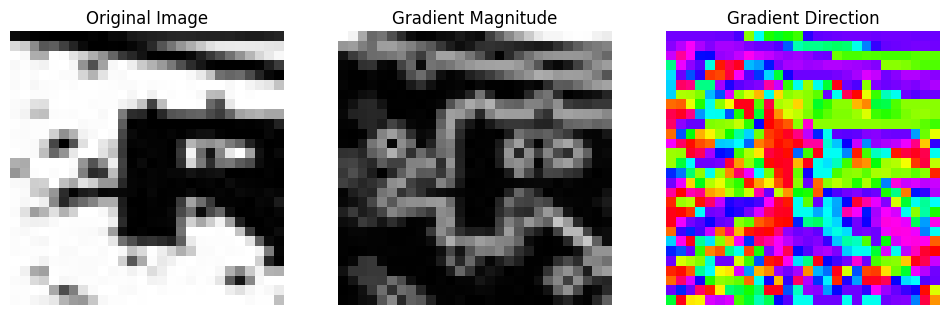

In [44]:
grad_magnitude, grad_direction = calculate_gradient(image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(grad_magnitude, cmap="gray")
plt.title("Gradient Magnitude")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(grad_direction, cmap="hsv")
plt.title("Gradient Direction")
plt.axis("off")

In [45]:
def get_histogram(data, bins, weights=None):
    """
    Compute the histogram of a dataset manually.
    
    Parameters:
        data (numpy.ndarray): Input data to bin.
        bins (numpy.ndarray): Array of bin edges.
        weights (numpy.ndarray or None): Weights for each data point.
    
    Returns:
        numpy.ndarray: The histogram counts (or weighted sum) for each bin.
    """
    # Ensure input is a NumPy array
    data = np.asarray(data)
    bins = np.asarray(bins)
    weights = np.asarray(weights) if weights is not None else np.ones_like(data)
    
    # Initialize the histogram with zeros
    histogram = np.zeros(len(bins) - 1, dtype=np.float64)
    
    # Iterate over each data point
    for value, weight in zip(data.flatten(), weights.flatten()):
        # Find the appropriate bin index
        for i in range(len(bins) - 1):
            if bins[i] <= value < bins[i + 1]:
                histogram[i] += weight
                break
        # Special case: include the last bin edge as part of the last bin
        if value == bins[-1]:
            histogram[-1] += weight
    
    return histogram


In [46]:
def calculate_hog_image(image, orientations=9, pixels_per_cell=(4, 4)):
    """
    Calculate the Histogram of Oriented Gradients (HOG) for a given image.
    
    Parameters:
        image (numpy.ndarray): Input image.
        orientations (int): Number of orientation bins.
        pixels_per_cell (tuple): Size (in pixels) of a cell.
        cells_per_block (tuple): Number of cells in each block.
    
    Returns:
        numpy.ndarray: HOG image.
    """

    # Calculate the gradient magnitude and direction
    grad_magnitude, grad_direction = calculate_gradient(image)

    # Define the number of orientation bins
    orientation_bins = np.linspace(0, np.pi, orientations + 1)

    # Compute the histogram of gradients
    img_width, img_height = image.shape
    cell_size_x, cell_size_y = pixels_per_cell

    hog_width, hog_height = (img_width // cell_size_x, img_height // cell_size_y)

    hog_image = np.zeros((hog_width, hog_height, orientations), dtype=np.float64)

    for y in range(0, image.shape[0], cell_size_y):
      for x in range(0, image.shape[1], cell_size_x):
        # Define the region of interest
        roi_direction = grad_direction[y:y + cell_size_y, x:x + cell_size_x]
        roi_magnitude = grad_magnitude[y:y + cell_size_y, x:x + cell_size_x]

        # Compute the histogram of gradients for the region of interest
        histogram, _ = np.histogram(roi_direction, orientation_bins, weights=roi_magnitude)

        # Update the HOG image
        hog_image[y:y + cell_size_y, x:x + cell_size_x] = histogram

    return hog_image

In [47]:
def calculate_gradient2(channel): 
  g_row = np.empty(channel.shape, dtype=channel.dtype)
  g_row[0, :] = 0
  g_row[-1, :] = 0
  g_row[1:-1, :] = channel[2:, :] - channel[:-2, :]
  g_col = np.empty(channel.shape, dtype=channel.dtype)
  g_col[:, 0] = 0
  g_col[:, -1] = 0
  g_col[:, 1:-1] = channel[:, 2:] - channel[:, :-2]

  return g_row, g_col

In [48]:
import _hoghistogram

def calculate_hog_image2(image, orientations=9, pixels_per_cell=(4, 4)):
    """
    Calculate the Histogram of Oriented Gradients (HOG) for a given image.
    
    Parameters:
        image (numpy.ndarray): Input image.
        orientations (int): Number of orientation bins.
        pixels_per_cell (tuple): Size (in pixels) of a cell.
        cells_per_block (tuple): Number of cells in each block.
    
    Returns:
        numpy.ndarray: HOG image.
    """

    # Calculate the gradient magnitude and direction
    Gx, Gy = calculate_gradient2(image)

    img_width, img_height = image.shape
    cell_size_x, cell_size_y = pixels_per_cell
    hog_width, hog_height = (img_width // cell_size_x, img_height // cell_size_y)

    hog_image = np.zeros((hog_width, hog_height, orientations), dtype=np.float64)

    _hoghistogram.hog_histograms(Gy, Gx,
                                 cell_size_x, cell_size_y,
                                 img_width, img_height,
                                 hog_width, hog_height,
                                 orientations, hog_image)

    return hog_image

hog_image = calculate_hog_image2(image, orientations=9, pixels_per_cell=(7, 7))
print(hog_image.shape)

(4, 4, 9)


In [49]:
def get_hog_features(image):
  hog_image = calculate_hog_image2(image)
  flattened_hog = hog_image.reshape(-1)
  return flattened_hog


In [50]:
def get_artifical_hog_features(image):
  hog_image = hog(image, orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=False)
  return hog_image


In [ ]:
X_hog_train = np.array([get_hog_features(image) for image in X_train])
# X_hog_train = np.array([get_artifical_hog_features(image) for image in X_train])

scaler = MinMaxScaler()
X_hog_train = scaler.fit_transform(X_hog_train)

print(X_hog_train.shape)
print(X_hog_train[0])

In [21]:
K.clear_session()
# Sequential layer
model = Sequential()

2025-01-11 16:47:52.734877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-11 16:47:52.735389: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
# fully connected layer
model.add(Dense(441, activation='relu', input_shape=(441,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 441)               194922    
                                                                 
 dropout (Dropout)           (None, 441)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               56576     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 36)                2

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
print(X_hog_train.shape)
print(Y_train.shape)

(47982, 441)
(47982, 36)


In [ ]:
response = model.fit(X_hog_train, Y_train, 
          batch_size=128, epochs=100, verbose=1)

Epoch 1/100
375/375 [==============================] - 3s 6ms/step - loss: 3.5854 - accuracy: 0.0303
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 3.5837 - accuracy: 0.0328
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 3.5832 - accuracy: 0.0329
Epoch 4/100
375/375 [==============================] - 2s 6ms/step - loss: 3.5831 - accuracy: 0.0331
Epoch 5/100
375/375 [==============================] - 2s 5ms/step - loss: 3.5832 - accuracy: 0.0331
Epoch 6/100
375/375 [==============================] - 2s 5ms/step - loss: 3.5831 - accuracy: 0.0331
Epoch 7/100
375/375 [==============================] - 2s 5ms/step - loss: 3.5830 - accuracy: 0.0334
Epoch 8/100
375/375 [==============================] - 2s 5ms/step - loss: 3.5829 - accuracy: 0.0327
Epoch 9/100
375/375 [==============================] - 2s 5ms/step - loss: 3.5825 - accuracy: 0.0330
Epoch 10/100
300/375 [=======================>......] - ETA: 0s - loss: 3.5826 - accuracy: 

KeyboardInterrupt: 